In [1]:
import allel
import sys
import numpy as np
import zarr
import pandas as pd
import numcodecs
import ipytree

# Introduction:

- This notebook is a demonstration of how to transfer the data from the 1000 Genomes VCF files - downloadable from https://www.internationalgenome.org/data-portal/data-collection/30x-grch38 - into the zarr format used for the web server.

# Load 1000 Genomes VCF Data and Save to Zarr Format:

#### Source: 
 http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20201028_3202_raw_GT_with_annot/

In [1]:
# Compressed file path:
# Please update to include your own local copy of the above data:
vcf_path = 'path/20201028_CCDG_14151_B01_GRM_WGS_2020-08-05_chr22.recalibrated_variants.vcf.gz'

In [112]:
# Specifying Zarr path to save to:
zarr_path = 'Data/FINAL_30x_GR38_NoBiIndel.zarr'

In [4]:
# Saving vcf file as Zarr file:
allel.vcf_to_zarr(vcf_path, zarr_path, 
                  group='22',                                    # chromosome no.
                  fields='*',                                    # include all fields
                  alt_number=1,                                  # will retain only biallelic alleles, so set to 1
                  log=sys.stdout,                                # print log of progress
                  compressor=numcodecs.Blosc(cname='zstd', clevel=1, shuffle=False))

[vcf_to_zarr] 65536 rows in 332.24s; chunk in 332.24s (197 rows/s); chr22 :11330023
[vcf_to_zarr] 131072 rows in 732.22s; chunk in 399.98s (163 rows/s); chr22 :12057633
[vcf_to_zarr] 196608 rows in 1164.22s; chunk in 432.00s (151 rows/s); chr22 :12692049
[vcf_to_zarr] 262144 rows in 1549.30s; chunk in 385.08s (170 rows/s); chr22 :15832505
[vcf_to_zarr] 327680 rows in 1909.75s; chunk in 360.44s (181 rows/s); chr22 :16763276
[vcf_to_zarr] 393216 rows in 2328.69s; chunk in 418.95s (156 rows/s); chr22 :18098362
[vcf_to_zarr] 458752 rows in 2676.99s; chunk in 348.29s (188 rows/s); chr22 :19769928
[vcf_to_zarr] 524288 rows in 3061.01s; chunk in 384.02s (170 rows/s); chr22 :21097642
[vcf_to_zarr] 589824 rows in 3449.84s; chunk in 388.84s (168 rows/s); chr22 :22401737
[vcf_to_zarr] 655360 rows in 3914.40s; chunk in 464.56s (141 rows/s); chr22 :23504624
[vcf_to_zarr] 720896 rows in 4324.03s; chunk in 409.63s (159 rows/s); chr22 :24822917
[vcf_to_zarr] 786432 rows in 4720.74s; chunk in 396.71s (

### Some Background on Zarr:

- The code above transfers the compressed vcf file obtained from the 1000 Genomes project into a a chunked zarr format. 
- An example of how this chunking occurs is showing below, as a 372GB array is divided into 2000 chunks. 
- Further information on Zarr can be found at: https://zarr.readthedocs.io/en/stable/. 
- It utilizes Numcodes (https://numcodecs.readthedocs.io/en/stable/) to provide the compression codec and above this has been set to Blosc. 
- The zarr format allows reading and writing of data in parrallel in n-dimensional compressed chunks, and uses lazy evaluation to ensure RAM usage remains low when loading the data object. See this blog post for more information: https://coiled.io/blog/save-numpy-dask-array-to-zarr/

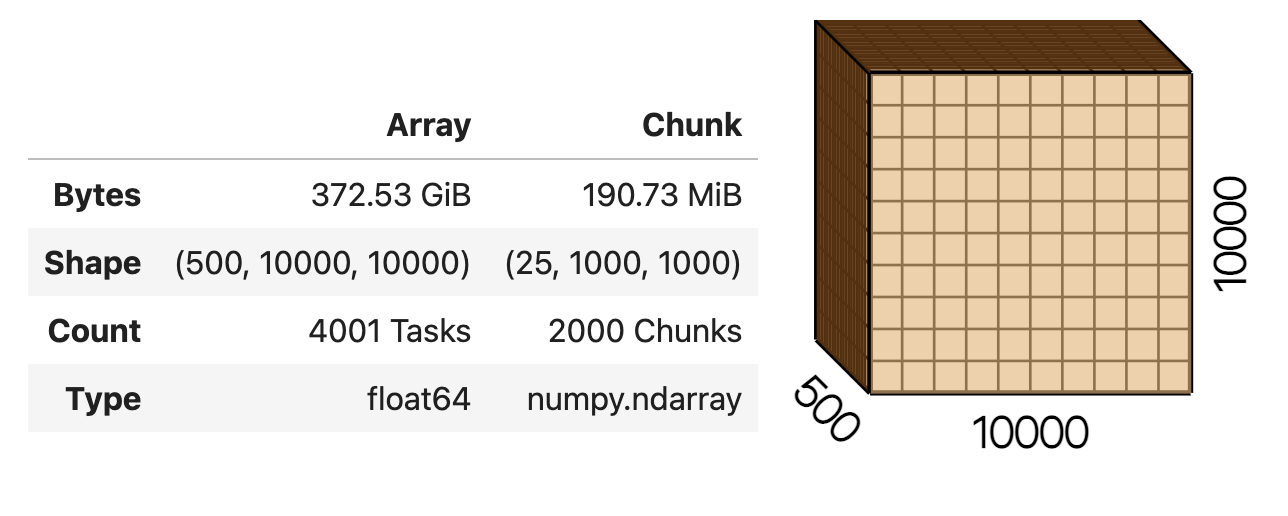

# Loading Resulting Zarr File:

In [115]:
# Create callset group:
callset = zarr.open_group(zarr_path, mode='r')
# Setting chromosome to be used:
chrom = '22'

In [124]:
# Display a tree of the Zarr data:
callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='22', nodes=(Node(disabled=True, nam…

## Loading Variants Data:

In [113]:
variants = allel.VariantChunkedTable(callset[chrom]['variants'], 
                         names=['CHROM', 'POS', 'REF', 'ALT', 'GENE1', 'GENE2', 'RS_VAL', 'numalt', 'AA',
                                'AF_AFR', 'AF_AMR', 'AF_EAS', 'AF_EUR', 'AF_SAS',
                                'DAF_AFR', 'DAF_AMR', 'DAF_EAS', 'DAF_EUR', 'DAF_SAS',
                                'GF_HET_AFR', 'GF_HOM_REF_AFR','GF_HOM_ALT_AFR',
                                'GF_HET_AMR', 'GF_HOM_REF_AMR', 'GF_HOM_ALT_AMR',
                                'GF_HET_EAS', 'GF_HOM_REF_EAS', 'GF_HOM_ALT_EAS', 
                                'GF_HET_EUR', 'GF_HOM_REF_EUR', 'GF_HOM_ALT_EUR',
                                'GF_HET_SAS', 'GF_HOM_REF_SAS', 'GF_HOM_ALT_SAS',
                               ],
                         index=('CHROM','POS'))

### Filtering for Biallelic SNPs:

In [20]:
# Exclude biallelic sites using the numalt column
bial_var_mask = variants.eval('numalt < 2')
bial_var_mask

<ChunkedArrayWrapper shape=(1927372,) dtype=bool chunks=(240922,)
   nbytes=1.8M cbytes=365.7K cratio=5.1
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [10]:
# Reducing the variants table to keep only biallelic sites:
variants_comp = variants.compress(bial_var_mask)
variants_comp

<VariantChunkedTable shape=(1732983,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O'), ('GENE', '<U17'), ('RS_VAL', '<U12'), ('numalt', '<i4'), ('AF_AFR', '<f4'), ('AF_AMR', '<f4'), ('AF_EAS', '<f4'), ('AF_EUR', '<f4'), ('AF_SAS', '<f4'), ('DAF_AFR', '<f8'), ('DAF_AMR', '<f8'), ('DAF_EAS', '<f8'), ('DAF_EUR', '<f8'), ('DAF_SAS', '<f8'), ('GF_HET_AFR', '<f8'), ('GF_HOM_REF_AFR', '<f8'), ('GF_HOM_ALT_AFR', '<f8'), ('GF_HET_AMR', '<f8'), ('GF_HOM_REF_AMR', '<f8'), ('GF_HOM_ALT_AMR', '<f8'), ('GF_HET_EAS', '<f8'), ('GF_HOM_REF_EAS', '<f8'), ('GF_HOM_ALT_EAS', '<f8'), ('GF_HET_EUR', '<f8'), ('GF_HOM_REF_EUR', '<f8'), ('GF_HOM_ALT_EUR', '<f8'), ('GF_HET_SAS', '<f8'), ('GF_HOM_REF_SAS', '<f8'), ('GF_HOM_ALT_SAS', '<f8')]
   nbytes=542.1M cbytes=191.8M cratio=2.8
   values=allel.chunked.storage_zarr.ZarrTable>

### Filtering for Indels:

In [51]:
alt_arr = variants_comp['REF'][:]

# Creating mask of all SNPs longer than one base in the ALT column:
alt_len_mask = [len(x) == 1 for x in alt_arr]

In [61]:
np.size(alt_len_mask) - np.count_nonzero(alt_len_mask)

44107

In [60]:
variants_no_ind = variants_comp.compress(alt_len_mask)
variants_no_ind

<VariantChunkedTable shape=(1688876,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O'), ('GENE', '<U17'), ('RS_VAL', '<U12'), ('numalt', '<i4'), ('AF_AFR', '<f4'), ('AF_AMR', '<f4'), ('AF_EAS', '<f4'), ('AF_EUR', '<f4'), ('AF_SAS', '<f4'), ('DAF_AFR', '<f8'), ('DAF_AMR', '<f8'), ('DAF_EAS', '<f8'), ('DAF_EUR', '<f8'), ('DAF_SAS', '<f8'), ('GF_HET_AFR', '<f8'), ('GF_HOM_REF_AFR', '<f8'), ('GF_HOM_ALT_AFR', '<f8'), ('GF_HET_AMR', '<f8'), ('GF_HOM_REF_AMR', '<f8'), ('GF_HOM_ALT_AMR', '<f8'), ('GF_HET_EAS', '<f8'), ('GF_HOM_REF_EAS', '<f8'), ('GF_HOM_ALT_EAS', '<f8'), ('GF_HET_EUR', '<f8'), ('GF_HOM_REF_EUR', '<f8'), ('GF_HOM_ALT_EUR', '<f8'), ('GF_HET_SAS', '<f8'), ('GF_HOM_REF_SAS', '<f8'), ('GF_HOM_ALT_SAS', '<f8')]
   nbytes=528.3M cbytes=178.9M cratio=3.0
   values=allel.chunked.storage_zarr.ZarrTable>

In [62]:
ref_arr = variants_no_ind['REF'][:]

# Creating mask of all SNPs longer than one base in the REF column:
ref_len_mask = [len(x) == 1 for x in ref_arr]

In [63]:
np.size(ref_len_mask) - np.count_nonzero(ref_len_mask)

85479

In [64]:
variants_no_ind = variants_no_ind.compress(ref_len_mask)
variants_no_ind

<VariantChunkedTable shape=(1603397,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O'), ('GENE', '<U17'), ('RS_VAL', '<U12'), ('numalt', '<i4'), ('AF_AFR', '<f4'), ('AF_AMR', '<f4'), ('AF_EAS', '<f4'), ('AF_EUR', '<f4'), ('AF_SAS', '<f4'), ('DAF_AFR', '<f8'), ('DAF_AMR', '<f8'), ('DAF_EAS', '<f8'), ('DAF_EUR', '<f8'), ('DAF_SAS', '<f8'), ('GF_HET_AFR', '<f8'), ('GF_HOM_REF_AFR', '<f8'), ('GF_HOM_ALT_AFR', '<f8'), ('GF_HET_AMR', '<f8'), ('GF_HOM_REF_AMR', '<f8'), ('GF_HOM_ALT_AMR', '<f8'), ('GF_HET_EAS', '<f8'), ('GF_HOM_REF_EAS', '<f8'), ('GF_HOM_ALT_EAS', '<f8'), ('GF_HET_EUR', '<f8'), ('GF_HOM_REF_EUR', '<f8'), ('GF_HOM_ALT_EUR', '<f8'), ('GF_HET_SAS', '<f8'), ('GF_HOM_REF_SAS', '<f8'), ('GF_HOM_ALT_SAS', '<f8')]
   nbytes=501.6M cbytes=169.0M cratio=3.0
   values=allel.chunked.storage_zarr.ZarrTable>

### Saving Data:

In [74]:
col_names = variants_no_ind.names

In [83]:
for c in range(len(col_names)):
    save_file_loc = 'Data/NO_INDEL/variants/' + col_names[c]
    
    array = variants_no_ind[col_names[c]][:]
    
    # If dtype of array is object, save it as a string array instead:
    if array.dtype == 'O':
        array = array.astype('U')
        
    zarr.save(save_file_loc, array)

## Loading Genotypes and Phased Genotypes Data:

In [12]:
genotypes = allel.GenotypeChunkedArray(callset[chrom]['calldata']['GT'])
genotypes

<GenotypeChunkedArray shape=(1927372, 3202, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=11.5G cbytes=300.0M cratio=39.2
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': False, 'blocksize': 0}
   values=zarr.core.Array>

In [14]:
phased_genotypes = allel.GenotypeChunkedArray(callset[chrom]['calldata']['PH_GT'])
phased_genotypes

<GenotypeChunkedArray shape=(1070401, 3202, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=6.4G cbytes=158.8M cratio=41.2
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': False, 'blocksize': 0}
   values=zarr.core.Array>

## Subsetting Genotype arrays based on biallelic sites masks:

In [21]:
def subset_G_array(data, start_idx, stop_idx, mask, subset_type):
    
    """ Function to retain chunked compression during subsetting """

    # To subset by index:
    if subset_type == 'index':
        data = allel.chunked.core.subset(data, range(start_idx, stop_idx))
    # To subset according to a mask:
    elif subset_type == 'mask':
        data = allel.chunked.core.compress(mask, data)
    
    # Convert back to a chunked Genotype array:
    data = allel.GenotypeChunkedArray(data)
    
    return data

In [65]:
# Subsetting genotypes based on the various masks above for biallelic and indel SNPs:
g_bial = subset_G_array(genotypes, None, None, bial_var_mask, 'mask')
g_bial = subset_G_array(g_bial, None, None, alt_len_mask, 'mask')
g_bial = subset_G_array(g_bial, None, None, ref_len_mask, 'mask')

In [66]:
g_bial

<GenotypeChunkedArray shape=(1603397, 3202, 2) dtype=int8 chunks=(783, 3202, 2)
   nbytes=9.6G cbytes=441.7M cratio=22.2
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [84]:
# Saving phased genotypes with only biallelic sites and no indels:
zarr.save('Data/FINAL_30x_GR38_NoBiIndel/calldata/GT_BI', g_bial)

## Subsetting Phased Genotypes array similarly:

In [41]:
ph_pos = np.array(callset[chrom]['variants']['PH_POS'])
ph_pos

array([10519265, 10519276, 10519325, ..., 50807850, 50807850, 50807929])

In [67]:
var_comp_pos = variants_no_ind['POS'][:]
var_comp_pos

array([10510061, 10510077, 10510103, ..., 50808157, 50808174, 50808180])

In [68]:
# Matching up POS locations:
ph_gen_mask = np.isin(ph_pos, var_comp_pos)
ph_gen_mask

array([False,  True,  True, ..., False, False, False])

In [69]:
# Subsetting based on the various masks above for biallelic and indel SNPs:
ph_g_bial = subset_G_array(phased_genotypes, None, None, ph_gen_mask, 'mask')

In [70]:
ph_g_bial

<GenotypeChunkedArray shape=(852917, 3202, 2) dtype=int8 chunks=(417, 3202, 2)
   nbytes=5.1G cbytes=269.4M cratio=19.3
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [85]:
# Saving phased genotypes with only biallelic sites:
zarr.save('Data/FINAL_30x_GR38_NoBiIndel/calldata/PH_GT_BI', ph_g_bial)

In [92]:
# Applying mask to ph_pos data:
ph_pos_bi = ph_pos[ph_gen_mask]

In [93]:
# Confirming same length as phased genotype array:
len(ph_pos_bi)

852917

In [94]:
# Saving to zarr:
zarr.save('Data/FINAL_30x_GR38_NoBiIndel/variants/PH_POS', ph_pos_bi)